<a href="https://colab.research.google.com/github/Hacxmr/Cyber_Threat_Detection/blob/main/Avishkar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow


In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Reshape
from tensorflow.keras.utils import to_categorical


import pandas as pd
import os

# Step 1: Load feature names (excluding header rows if any)
feature_meta = pd.read_csv("/content/UNSW_NB15/NUSW-NB15_features.csv", encoding='latin1')

# Step 2: Extract column names and append 'attack_cat' and 'label'
columns = feature_meta['Name'].tolist() + ['attack_cat', 'label']

# Step 3: Deduplicate column names by appending suffixes to duplicates
def deduplicate(names):
    seen = {}
    deduped = []
    for name in names:
        if name not in seen:
            seen[name] = 1
            deduped.append(name)
        else:
            seen[name] += 1
            deduped.append(f"{name}_{seen[name]}")
    return deduped

columns = deduplicate(columns)

# Step 4: Load the 4 parts of UNSW-NB15 dataset
folder = "/content/UNSW_NB15"
files = ["UNSW-NB15_1.csv", "UNSW-NB15_2.csv", "UNSW-NB15_3.csv", "UNSW-NB15_4.csv"]

df = pd.concat([
    pd.read_csv(os.path.join(folder, file), header=None, names=columns, low_memory=False)
    for file in files
], ignore_index=True)

# Step 5: Show shape and preview
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (2540047, 51)


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,attack_cat_2,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,7,1,3,1,1,1,NaN,0,NaN,NaN
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,4,2,3,1,1,2,NaN,0,NaN,NaN
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,8,1,2,2,1,1,NaN,0,NaN,NaN
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,9,1,1,1,1,1,NaN,0,NaN,NaN
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,9,1,1,1,1,1,NaN,0,NaN,NaN


In [4]:
# === Encode categorical columns ===
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

# === Features and target ===
X = df.drop(['label', 'attack_cat'], axis=1)
y = df['label']
y_cat = to_categorical(y)

# === Normalize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

# === Reshape for CNN/LSTM ===
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# === Define model builders ===

def build_dnn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64), input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# === Train and evaluate models ===
models = {
    'DNN': build_dnn(X_train.shape[1]),
    'CNN': build_cnn((X_train.shape[1], 1)),
    'LSTM': build_lstm((X_train.shape[1], 1)),
    'BiLSTM': build_bilstm((X_train.shape[1], 1)),
}

histories = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    if name == 'DNN':
        history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_test, y_test))
    else:
        history = model.fit(X_train_seq, y_train, epochs=5, batch_size=512, validation_data=(X_test_seq, y_test))
    histories[name] = history
    _, acc = model.evaluate(X_test_seq if name != 'DNN' else X_test, y_test)
    print(f"{name} Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


ValueError: negative dimensions are not allowed

In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Reshape
from sklearn.metrics import classification_report

# === Step 1: Load UNSW-NB15 Dataset ===

folder = "/content/UNSW_NB15"  # path to folder containing CSVs
files = ["UNSW-NB15_1.csv", "UNSW-NB15_2.csv", "UNSW-NB15_3.csv", "UNSW-NB15_4.csv"]
col_file = os.path.join(folder, "/content/UNSW_NB15/NUSW-NB15_features.csv")

# Read column names from UNSW-NB15_features.csv
col_df = pd.read_csv(col_file, encoding='latin1')
columns = col_df['Name'].tolist()


# Deduplicate columns (some are repeated)
_, idx = np.unique(columns, return_index=True)
columns = [columns[i] for i in sorted(idx)]

# Load all parts
df_list = []
for file in files:
    df_part = pd.read_csv(os.path.join(folder, file), header=None, low_memory=False)
    df_part.columns = columns
    df_list.append(df_part)

df = pd.concat(df_list, ignore_index=True)

# === Step 2: Preprocessing ===

# Drop non-numeric or categorical columns that can't be directly used
df.drop(['id', 'attack_cat'], axis=1, errors='ignore', inplace=True)

# Encode categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Drop rows with missing values
df = df.dropna()

# Separate features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# One-hot encode the label (binary classification)
y_cat = to_categorical(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 3: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

# === Step 4: Define Deep Learning Models ===

def build_mlp(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Reshape((input_shape, 1), input_shape=(input_shape,)),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    return model

def build_lstm(input_shape):
    model = Sequential([
        Reshape((input_shape, 1), input_shape=(input_shape,)),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    return model

# === Step 5: Train and Evaluate Models ===

def train_evaluate_model(model, name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.2, verbose=1)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_true, y_pred_classes))

# Train all models
mlp_model = build_mlp(X_train.shape[1])
cnn_model = build_cnn(X_train.shape[1])
lstm_model = build_lstm(X_train.shape[1])

train_evaluate_model(mlp_model, "MLP")
train_evaluate_model(cnn_model, "CNN")
train_evaluate_model(lstm_model, "LSTM")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training MLP...
Epoch 1/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9928 - loss: 0.0313 - val_accuracy: 0.9968 - val_loss: 0.0064
Epoch 2/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9968 - loss: 0.0067 - val_accuracy: 0.9970 - val_loss: 0.0058
Epoch 3/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9970 - loss: 0.0062 - val_accuracy: 0.9973 - val_loss: 0.0055
Epoch 4/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9972 - loss: 0.0054 - val_accuracy: 0.9974 - val_loss: 0.0055
Epoch 5/5
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9972 - loss: 0.0054 - val_accuracy: 0.9973 - val_loss: 0.0054
6796/6796 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

MLP Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212955
           1       0.93      0.94      0.94      4486

    accuracy                           1.00    217441
   macro avg       0.97      0.97      0.97  

In [16]:
import pandas as pd
from tabulate import tabulate

# Create a DataFrame with model performance
data = {
    "Metric": ["Accuracy", "Precision (Attack)", "Recall (Attack)", "F1-Score (Attack)", "Val Accuracy (Last Epoch)", "Training Time (5 Epochs)"],
    "MLP": ["100%", "0.93", "0.94", "0.94", "99.73%", "~50 sec"],
    "CNN": ["100%", "0.92", "0.95", "0.94", "99.74%", "~7 min"],
    "LSTM": ["100%", "0.89", "0.94", "0.92", "99.64%", "~22 min"]
}

df = pd.DataFrame(data)

# Display the table in a pretty format using tabulate
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))


╒═══════════════════════════╤═════════╤════════╤═════════╕
│ Metric                    │ MLP     │ CNN    │ LSTM    │
╞═══════════════════════════╪═════════╪════════╪═════════╡
│ Accuracy                  │ 100%    │ 100%   │ 100%    │
├───────────────────────────┼─────────┼────────┼─────────┤
│ Precision (Attack)        │ 0.93    │ 0.92   │ 0.89    │
├───────────────────────────┼─────────┼────────┼─────────┤
│ Recall (Attack)           │ 0.94    │ 0.95   │ 0.94    │
├───────────────────────────┼─────────┼────────┼─────────┤
│ F1-Score (Attack)         │ 0.94    │ 0.94   │ 0.92    │
├───────────────────────────┼─────────┼────────┼─────────┤
│ Val Accuracy (Last Epoch) │ 99.73%  │ 99.74% │ 99.64%  │
├───────────────────────────┼─────────┼────────┼─────────┤
│ Training Time (5 Epochs)  │ ~50 sec │ ~7 min │ ~22 min │
╘═══════════════════════════╧═════════╧════════╧═════════╛


In [14]:
print(df.columns.tolist())


['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label']


In [21]:
import pandas as pd

# Load the CSV
df_1 = pd.read_csv('/content/kdd_dataset.csv', header=None, low_memory=False)
print(f"Number of columns: {df_1.shape[1]}")



Number of columns: 44


In [23]:
import pandas as pd

df = pd.read_csv('/content/kdd_dataset.csv', header=None)  # Use `header=None` if the file has no column headers
print(df.head())  # Shows first 5 rows


    0         1              2         3     4          5          6     7   \
0  NaN  duration  protocol_type   service  flag  src_bytes  dst_bytes  land   
1  0.0         0            tcp  ftp_data    SF        491          0     0   
2  1.0         0            udp     other    SF        146          0     0   
3  2.0         0            tcp   private    S0          0          0     0   
4  3.0         0            tcp      http    SF        232       8153     0   

               8       9   ...                      34  \
0  wrong_fragment  urgent  ...  dst_host_same_srv_rate   
1               0       0  ...                    0.17   
2               0       0  ...                     0.0   
3               0       0  ...                     0.1   
4               0       0  ...                     1.0   

                       35                           36  \
0  dst_host_diff_srv_rate  dst_host_same_src_port_rate   
1                    0.03                         0.17   
2 

/tmp/ipython-input-23-1820333109.py:3: DtypeWarning: Columns (1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/kdd_dataset.csv', header=None)  # Use `header=None` if the file has no column headers


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148518 entries, 0 to 148517
Data columns (total 44 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       148517 non-null  float64
 1   1       148518 non-null  object 
 2   2       148518 non-null  object 
 3   3       148518 non-null  object 
 4   4       148518 non-null  object 
 5   5       148518 non-null  object 
 6   6       148518 non-null  object 
 7   7       148518 non-null  object 
 8   8       148518 non-null  object 
 9   9       148518 non-null  object 
 10  10      148518 non-null  object 
 11  11      148518 non-null  object 
 12  12      148518 non-null  object 
 13  13      148518 non-null  object 
 14  14      148518 non-null  object 
 15  15      148518 non-null  object 
 16  16      148518 non-null  object 
 17  17      148518 non-null  object 
 18  18      148518 non-null  object 
 19  19      148518 non-null  object 
 20  20      148518 non-null  object 
 21  21      14

In [25]:
import pandas as pd

# Step 1: Load the CSV without headers
df_raw = pd.read_csv('/content/kdd_dataset.csv', header=None, low_memory=False)

# Step 2: Extract the second row (index 0) as header
columns = df_raw.iloc[0].tolist()

# Step 3: Remove the first row and assign column names
df = df_raw[1:]  # Remove the header row
df.columns = columns  # Set column names

# Optional: reset index
df = df.reset_index(drop=True)

# Display column names
print("Total columns:", len(df.columns))
print(df.columns.tolist())


Total columns: 44
[np.float64(nan), 'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class', 'difficulty']


In [26]:
import pandas as pd

# Step 1: Load raw CSV without setting header
df_raw = pd.read_csv('/content/kdd_dataset.csv', header=None, low_memory=False)

# Step 2: Set second row as header
new_header = df_raw.iloc[0]  # First row contains actual column names
df = df_raw[1:]              # Remove the header row from the data
df.columns = new_header      # Assign column names

# Step 3: Reset index and optionally convert numeric columns
df.reset_index(drop=True, inplace=True)

# Optional: convert numeric columns (skip non-numeric like protocol_type, service, flag, class, difficulty)
numeric_cols = df.columns.difference(['protocol_type', 'service', 'flag', 'class', 'difficulty'])
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Optional: show types
print(df.dtypes.tail())
print("\n✅ DataFrame loaded successfully with shape:", df.shape)


0
dst_host_srv_serror_rate    float64
dst_host_rerror_rate        float64
dst_host_srv_rerror_rate    float64
class                        object
difficulty                   object
dtype: object

✅ DataFrame loaded successfully with shape: (148517, 44)


/tmp/ipython-input-26-1067089653.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [27]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['protocol_type', 'service', 'flag']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for inverse transform if needed


/tmp/ipython-input-27-392740308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
/tmp/ipython-input-27-392740308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
/tmp/ipython-input-27-392740308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [28]:
df['class'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)


/tmp/ipython-input-28-3349462598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)


In [29]:
from sklearn.model_selection import train_test_split

X = df.drop(['class', 'difficulty'], axis=1)  # drop label and unused column
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [31]:
import pandas as pd

# Load without headers
df_raw = pd.read_csv('/content/kdd_dataset.csv', header=None, low_memory=False)

# Set the first row as header, drop the original header row
df_raw.columns = df_raw.iloc[0]
df_raw = df_raw[1:].reset_index(drop=True)

# Optional: Convert all column names to strings
df_raw.columns = df_raw.columns.astype(str)


In [32]:
# Drop rows with missing values (optional but common)
df_raw = df_raw.dropna()

# Convert all features (except target) to numeric where possible
X = df_raw.drop(['class', 'difficulty'], axis=1).apply(pd.to_numeric, errors='coerce')
y = df_raw['class']

# Drop rows with NaNs again after conversion
X = X.dropna()
y = y[X.index]  # Align y with filtered X


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/kdd_dataset.csv')

# Show shape and head
print(df.shape)
df.head()


(148517, 44)


,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
0,0,0,tcp,ftp_data,SF,491,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,1,0,udp,other,SF,146,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,2,0,tcp,private,S0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,3,0,tcp,http,SF,232,8153,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,4,0,tcp,http,SF,199,420,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [5]:
print(df.columns)


Index(['Unnamed: 0', 'duration', 'protocol_type', 'service', 'flag',
       'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'difficulty'],
      dtype='object')


In [6]:
X = df.drop(columns=['class'])  # Features
y = df['class']                 # Target


In [7]:
from sklearn.preprocessing import LabelEncoder

for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [8]:
y = LabelEncoder().fit_transform(y)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# DNN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(set(y)), activation='softmax')  # Multi-class classification
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8522 - loss: 0.5944 - val_accuracy: 0.9806 - val_loss: 0.0813
Epoch 2/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9717 - loss: 0.1010 - val_accuracy: 0.9860 - val_loss: 0.0528
Epoch 3/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9786 - loss: 0.0753 - val_accuracy: 0.9871 - val_loss: 0.0466
Epoch 4/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9823 - loss: 0.0600 - val_accuracy: 0.9883 - val_loss: 0.0423
Epoch 5/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9832 - loss: 0.0556 - val_accuracy: 0.9891 - val_loss: 0.0349
Epoch 6/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9852 - loss: 0.0495 - val_accuracy: 0.9890 - val_loss: 0.0343
Epoch 7/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9862 - loss: 0.0450 - val_accuracy: 0.9893 - val_loss: 0.0343
Epoch 8/20
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9868 - loss: 0.0435 -

In [10]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Reshape, Input
import tensorflow as tf

def evaluate_model(model_fn, name, X_train, y_train, X_test, y_test, reshape=None):
    """
    model_fn: A function that returns a compiled Keras model.
    reshape: A tuple to reshape X_train/X_test to match input for CNN/LSTM.
    """
    if reshape:
        X_train_reshaped = X_train.reshape(reshape)
        X_test_reshaped = X_test.reshape(reshape)
    else:
        X_train_reshaped = X_train
        X_test_reshaped = X_test

    model = model_fn(input_shape=X_train_reshaped.shape[1:])

    start_time = time.time()
    history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test_reshaped, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true_labels, y_pred_labels)
    prec = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    rec = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

    val_acc = history.history['val_accuracy'][-1] * 100

    return {
        "Model": name,
        "Accuracy": f"{acc * 100:.2f}%",
        "Precision (Attack)": round(prec, 2),
        "Recall (Attack)": round(rec, 2),
        "F1-Score (Attack)": round(f1, 2),
        "Val Accuracy (Last Epoch)": f"{val_acc:.2f}%",
        "Training Time (5 Epochs)": f"~{round(training_time)} sec"
    }


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode on full dataset first
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Then split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [15]:
import numpy as np
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Reshape

# Ensure number of classes is correct
input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))

# Evaluation function
def evaluate_model(model, name, X_train, y_train, X_test, y_test, reshape=None):
    start_time = time.time()

    if reshape:
        X_train = X_train.reshape(reshape)
        X_test = X_test.reshape(reshape)

    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test, y_pred_labels)
    prec = precision_score(y_test, y_pred_labels, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, average='macro', zero_division=0)

    val_acc = history.history['val_accuracy'][-1] * 100

    return {
        "Model": name,
        "Accuracy": round(acc * 100, 2),
        "Precision (Attack)": round(prec, 2),
        "Recall (Attack)": round(rec, 2),
        "F1-Score (Attack)": round(f1, 2),
        "Val Accuracy": round(val_acc, 2),
        "Training Time": f"{round(elapsed_time / 60, 2)} min"
    }

# MLP Model
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CNN Model
cnn = Sequential([
    Reshape((input_dim, 1), input_shape=(input_dim,)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# LSTM Model
lstm = Sequential([
    Reshape((input_dim, 1), input_shape=(input_dim,)),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate All Models
results = []
results.append(evaluate_model(mlp, "MLP", X_train_scaled, y_train, X_test_scaled, y_test))
results.append(evaluate_model(cnn, "CNN", X_train_scaled, y_train, X_test_scaled, y_test, reshape=(-1, input_dim, 1)))
results.append(evaluate_model(lstm, "LSTM", X_train_scaled, y_train, X_test_scaled, y_test, reshape=(-1, input_dim, 1)))

# Show Results
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
929/929 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
  Model  Accuracy  Precision (Attack)  Recall (Attack)  F1-Score (Attack)  \
0   MLP     51.88                0.01             0.03               0.02   
1   CNN     51.88                0.01             0.03               0.02   
2  LSTM     51.88                0.01             0.03               0.02   

   Val Accuracy Training Time  
0         51.89      0.42 min  
1         51.88      1.04 min  
2         51.89       6.2 min  


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Feature scaling (important for neural nets)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow as tf

# If binary classification: use sigmoid
num_classes = len(np.unique(y_train))
loss_fn = 'binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy'
activation_out = 'sigmoid' if num_classes == 2 else 'softmax'

# One-hot encode for categorical
if num_classes > 2:
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

# MLP model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation=activation_out)
])

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights_dict if num_classes == 2 else None,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8772 - loss: 0.5800 - val_accuracy: 0.9824 - val_loss: 0.0689
Epoch 2/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9740 - loss: 0.0929 - val_accuracy: 0.9863 - val_loss: 0.0474
Epoch 3/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9807 - loss: 0.0711 - val_accuracy: 0.9882 - val_loss: 0.0386
Epoch 4/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9825 - loss: 0.0593 - val_accuracy: 0.9897 - val_loss: 0.0344
Epoch 5/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9840 - loss: 0.0531 - val_accuracy: 0.9902 - val_loss: 0.0339
Epoch 6/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9851 - loss: 0.0477 - val_accuracy: 0.9911 - val_loss: 0.0298
Epoch 7/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9872 - loss: 0.0457 - val_accuracy: 0.9919 - val_loss: 0.0288
Epoch 8/50
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9870 - loss: 0.0423 - 

In [20]:
import numpy as np

# Convert one-hot encoded y_test to class indices
y_test_labels = np.argmax(y_test, axis=1)

# Now use inverse_transform instead of transform to decode the integer labels
y_test_decoded = le.inverse_transform(y_test_labels)


Accuracy: 0.9924589280904929

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.98      1.00      0.99       263
           2       0.71      0.50      0.59        10
           3       0.00      0.00      0.00         2
           4       0.94      0.99      0.97       257
           5       1.00      0.93      0.96        27
           6       0.00      0.00      0.00         2
           7       0.97      0.99      0.98       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.96      0.90      0.93        59
          11       0.98      0.98      0.98       199
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00      9174
          15       0.96      0.98      0.97       313
          16       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


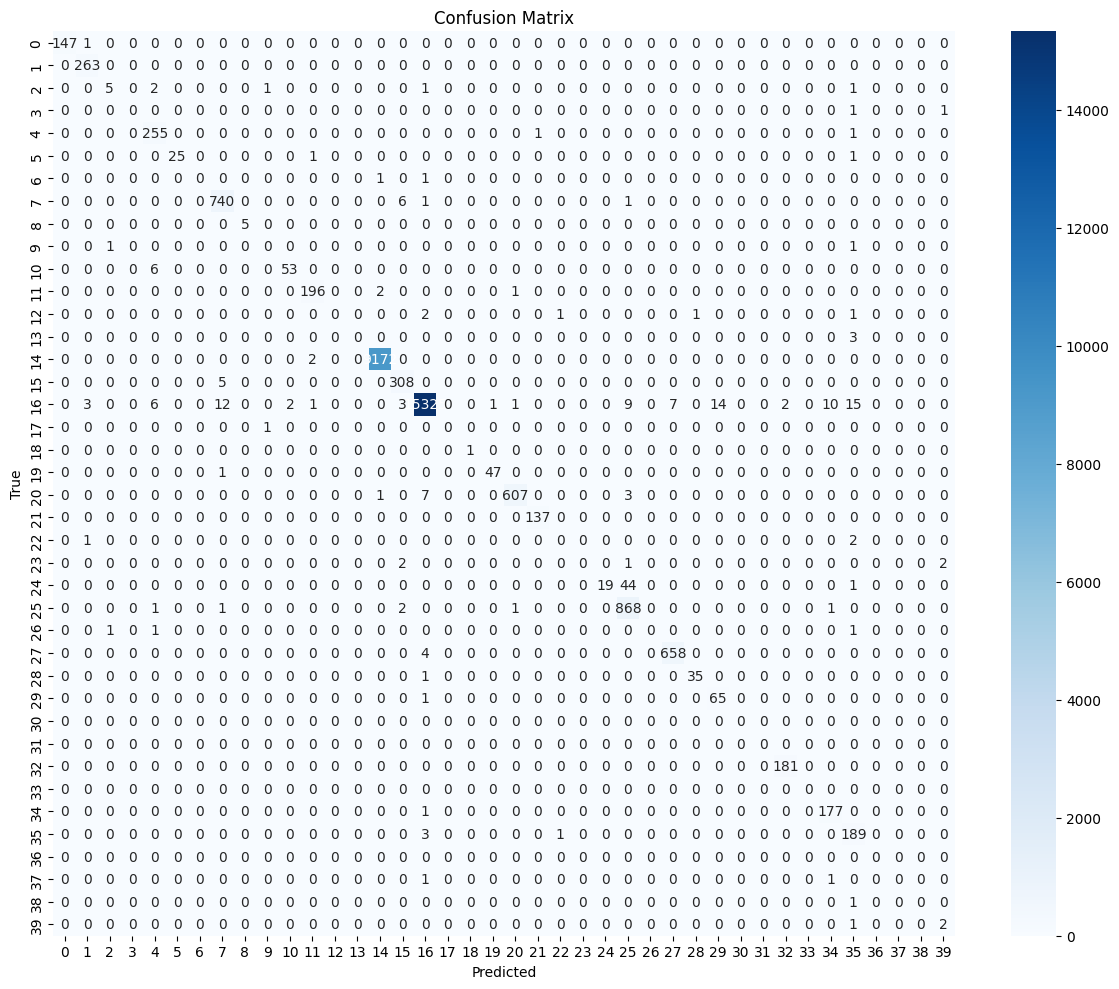

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Convert one-hot encoded y_test to class indices
y_test_labels = np.argmax(y_test, axis=1)

# Step 2: Decode true labels (optional, if you want string labels back)
y_test_decoded = le.inverse_transform(y_test_labels)

# Step 3: Convert predicted probabilities to class indices
y_pred_labels = y_pred  # Already predicted labels


# Step 4: Decode predicted labels (optional)
y_pred_decoded = le.inverse_transform(y_pred_labels)

# Step 5: Print evaluation metrics
print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

# Optional: Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, xticklabels=le.classes_, yticklabels=le.classes_, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Accuracy: 0.9924589280904929

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.98      1.00      0.99       263
           2       0.71      0.50      0.59        10
           3       0.00      0.00      0.00         2
           4       0.94      0.99      0.97       257
           5       1.00      0.93      0.96        27
           6       0.00      0.00      0.00         2
           7       0.97      0.99      0.98       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.96      0.90      0.93        59
          11       0.98      0.98      0.98       199
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00      9174
          15       0.96      0.98      0.97       313
          16       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


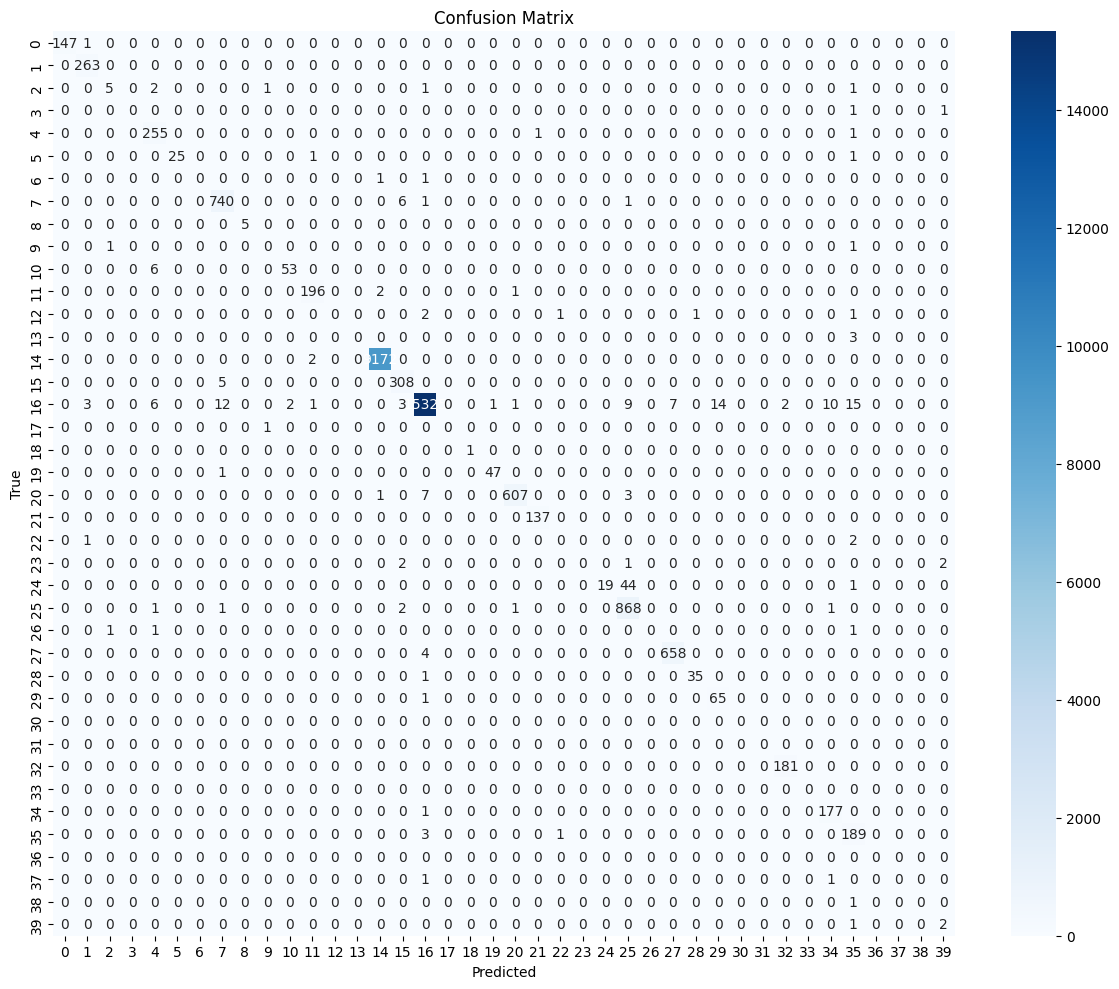

In [23]:
# Step 4: Decode predicted labels (optional)
y_pred_decoded = le.inverse_transform(y_pred_labels)

# Step 5: Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, xticklabels=le.classes_, yticklabels=le.classes_, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Test Accuracy: 0.9924589280904929

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.98      1.00      0.99       263
           2       0.71      0.50      0.59        10
           3       0.00      0.00      0.00         2
           4       0.94      0.99      0.97       257
           5       1.00      0.93      0.96        27
           6       0.00      0.00      0.00         2
           7       0.97      0.99      0.98       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.96      0.90      0.93        59
          11       0.98      0.98      0.98       199
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00      9174
          15       0.96      0.98  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


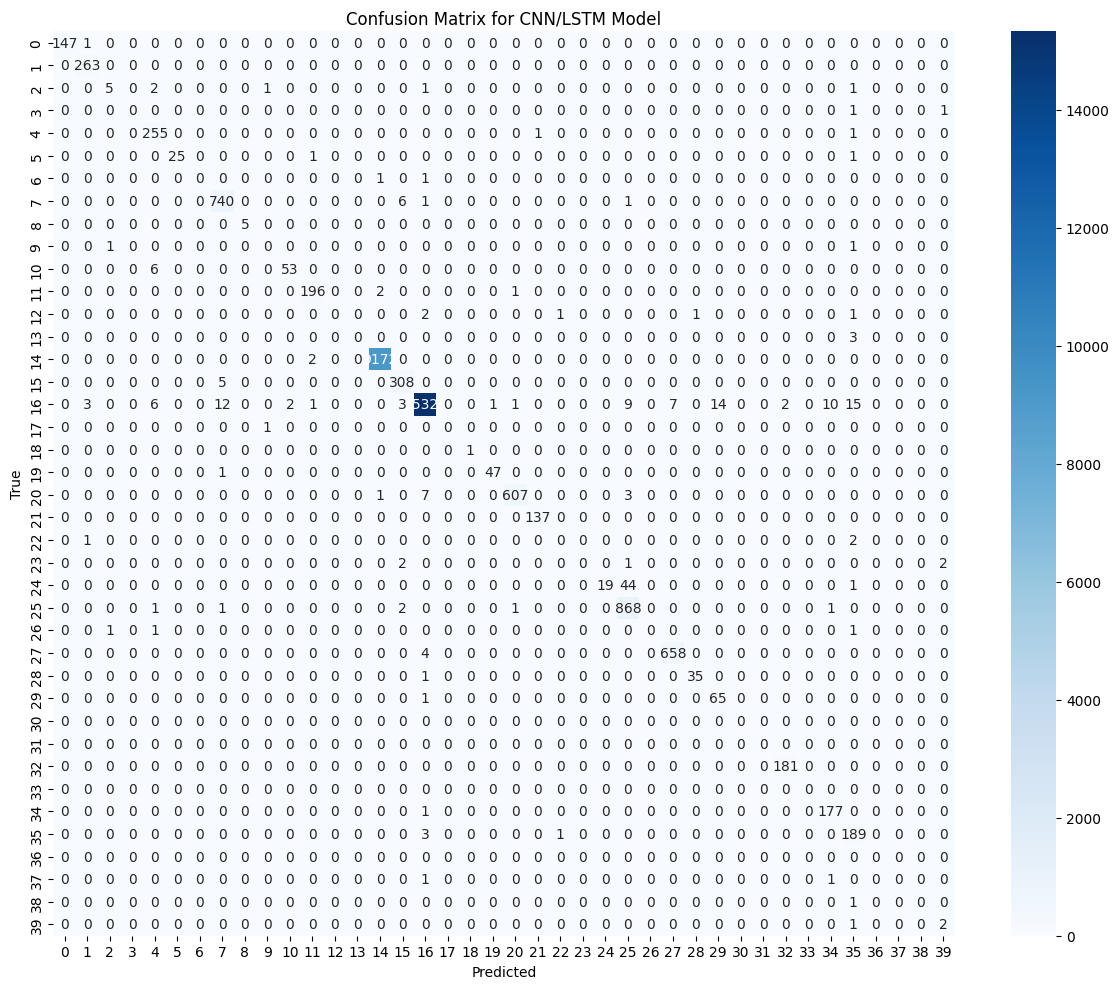

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predict class probabilities on test set
y_pred_probs = model.predict(X_test)

# 2. Convert probabilities to predicted class indices
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 3. If y_test was one-hot encoded, convert it back to class indices
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# 4. Decode labels if you used LabelEncoder
# Assuming le is your LabelEncoder
y_pred_decoded = le.inverse_transform(y_pred_labels)
y_test_decoded = le.inverse_transform(y_test_labels)

# 5. Print Accuracy and Classification Report
print("Test Accuracy:", accuracy_score(y_test_decoded, y_pred_decoded))
print("\nClassification Report:\n")
print(classification_report(y_test_decoded, y_pred_decoded))

# 6. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, xticklabels=le.classes_, yticklabels=le.classes_,
            annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN/LSTM Model')
plt.tight_layout()
plt.show()


In [35]:
# X: shape (num_samples, num_features)
# y: one-hot encoded using to_categorical or LabelEncoder + OneHotEncoder

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Label encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)             # shape (num_samples,)
y_onehot = to_categorical(y_encoded)        # shape (num_samples, num_classes)

# Reshape input for CNN/LSTM
X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))  # (samples, timesteps, features)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42)


In [36]:
# Reshape input for Conv1D: (samples, time_steps, features)
X_cnn = X.values.reshape((X.shape[0], X.shape[1], 1))


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

cnn_model = Sequential([
    Input(shape=(X_cnn.shape[1], X_cnn.shape[2])),  # (time_steps, features)
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Multi-class output
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 41, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,840 (331.41 KB)

 Trainable params: 84,840 (331.41 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.4824 - loss: 336.0313 - val_accuracy: 0.5253 - val_loss: 1.5157
Epoch 2/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5224 - loss: 1.4955 - val_accuracy: 0.5219 - val_loss: 1.4650
Epoch 3/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5225 - loss: 1.4585 - val_accuracy: 0.5226 - val_loss: 1.4566
Epoch 4/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5198 - loss: 1.4552 - val_accuracy: 0.5257 - val_loss: 1.4520
Epoch 5/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.5221 - loss: 1.4520 - val_accuracy: 0.5239 - val_loss: 1.4535
Epoch 6/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5192 - loss: 1.4545 - val_accuracy: 0.5288 - val_loss: 1.4506
Epoch 7/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5216 - loss: 1.5894 - val_accuracy: 0.5226 - val_loss: 1.4551
Epoch 8/10
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.5198 - loss:

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_cnn_scaled = scaler.fit_transform(X_cnn.reshape(-1, X_cnn.shape[-1])).reshape(X_cnn.shape)


In [40]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_cnn_scaled.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 41, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 41, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 18, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,715 (389.51 KB)

 Trainable params: 99,331 (388.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # for 3 classes (adjust if needed)
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 41, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 18, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,763 (710.01 KB)

 Trainable params: 181,379 (708.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [44]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer

cnn_model = Sequential([
    InputLayer(input_shape=(X_cnn.shape[1], X_cnn.shape[2])),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [45]:
# Suppose you have 49 features, reshape to (samples, 49, 1)
X_cnn = X.values.reshape((X.shape[0], X.shape[1], 1))


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

cnn_model.fit(X_train, y_train,
              epochs=25,
              batch_size=32,
              validation_data=(X_test, y_test))


Epoch 1/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.8904 - loss: 0.4864 - val_accuracy: 0.8898 - val_loss: 0.4617
Epoch 2/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.8748 - loss: 18.7970 - val_accuracy: 0.8694 - val_loss: 0.5525
Epoch 3/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - accuracy: 0.8789 - loss: 0.5262 - val_accuracy: 0.8908 - val_loss: 0.4633
Epoch 4/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.8881 - loss: 0.5262 - val_accuracy: 0.8926 - val_loss: 0.5153
Epoch 5/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.8878 - loss: 0.5254 - val_accuracy: 0.8926 - val_loss: 0.4877
Epoch 6/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8917 - loss: 0.5283 - val_accuracy: 0.8994 - val_loss: 0.4846
Epoch 7/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8920 - loss: 0.5234 - val_accuracy: 0.8975 - val_loss: 0.4800
Epoch 8/25
3713/3713 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.8952 - l

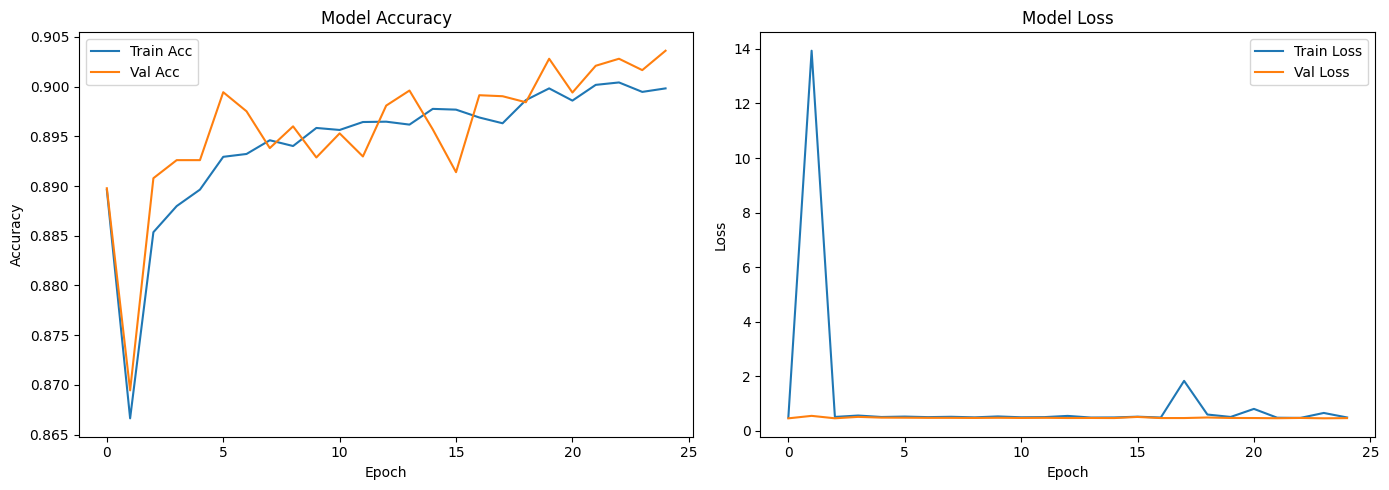

In [48]:
import matplotlib.pyplot as plt

history = cnn_model.history

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


929/929 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9022 - loss: 0.4718
Test Accuracy: 0.9036, Test Loss: 0.4701


929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.00      0.00      0.00       271
           2       0.00      0.00      0.00        11
           4       0.00      0.00      0.00       243
           5       0.00      0.00      0.00        32
           6       0.00      0.00      0.00         3
           7       0.99      0.85      0.92       698
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        50
          11       0.80      0.55      0.65       215
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         5
          14       1.00      1.00      1.00      9147
          15       0.97      0.63      0.77       333
          16       0.87      1.00      0.93     15450
          17       0.00      0.00      0.00         1
          19       0.00    

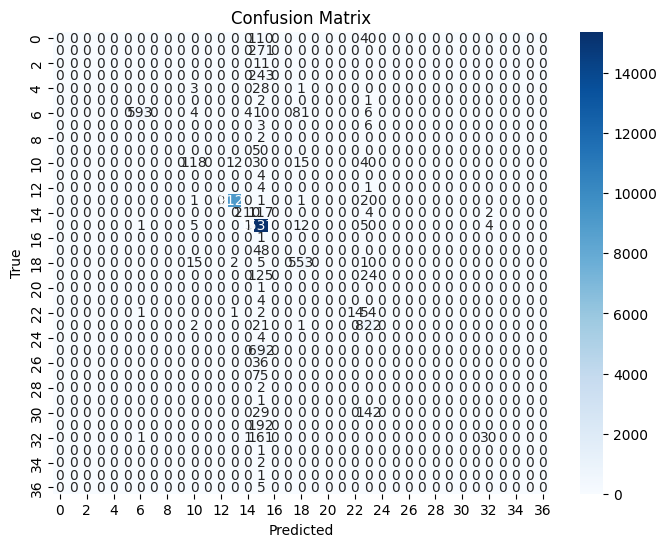

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Report
print(classification_report(y_test, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
